In [2]:
import json
import statistics
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, precision_recall_curve, confusion_matrix, RocCurveDisplay, auc, make_scorer, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, RepeatedEditedNearestNeighbours
from preprocess_data.process_ground_truth import reform_ground_truth, ground_truth_sep
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
import seaborn as sns
import os
import random

In [3]:
def compress_data(data, resolution):
    compressed = {}
    for name in data.keys():
        compressed[name] = {}
        compressed[name]['average'] = []
        compressed[name]['variance'] = []
        compressed[name]['peak'] = []
        for i in range(0, len(data[name]), resolution):
            compressed[name]['average'].append(statistics.mean(data[name][i:i + resolution]))
            compressed[name]['variance'].append(statistics.variance(data[name][i:i + resolution]))
            compressed[name]['peak'].append(max(data[name][i:i + resolution], key=abs))
    return compressed


def feature_matrix(window, compressed_swa, compressed_longitudinal_acc, compressed_lateral_acc, flag, b):
    cases = 0
    # true | true_window['catia'][0](这是对应的秒数，一个数列）compressed_swa['catia']['average'][true_window['catia'][0]]
    matrix = []
    for name in window.keys():
        cases += len(window[name])
        for i in range(0, len(window[name])):
            temp = []
            if flag == 1:
                for j in window[name][i]:
                    temp.extend(compressed_swa[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_swa[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_swa[name]['peak'][b * j:b * (j + 1)])
            if flag == 2:
                for j in window[name][i]:
                    temp.extend(compressed_lateral_acc[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_lateral_acc[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_lateral_acc[name]['peak'][b * j:b * (j + 1)])
            if flag == 3:
                for j in window[name][i]:
                    temp.extend(compressed_longitudinal_acc[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_longitudinal_acc[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_longitudinal_acc[name]['peak'][b * j:b * (j + 1)])
            if flag == 4:
                for j in window[name][i]:
                    temp.extend(compressed_lateral_acc[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_lateral_acc[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_lateral_acc[name]['peak'][b * j:b * (j + 1)])
                for j in window[name][i]:
                    temp.extend(compressed_longitudinal_acc[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_longitudinal_acc[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_longitudinal_acc[name]['peak'][b * j:b * (j + 1)])
            if flag == 5:
                for j in window[name][i]:
                    temp.extend(compressed_swa[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_swa[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_swa[name]['peak'][b * j:b * (j + 1)])
                for j in window[name][i]:
                    temp.extend(compressed_lateral_acc[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_lateral_acc[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_lateral_acc[name]['peak'][b * j:b * (j + 1)])
                for j in window[name][i]:
                    temp.extend(compressed_longitudinal_acc[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_longitudinal_acc[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_longitudinal_acc[name]['peak'][b * j:b * (j + 1)])
            matrix.append(temp)
            
    matrix=np.array(matrix)        

    return matrix, cases


In [4]:
def confusion_matrix_on_test_data(model,model_name, X_test, y_test):
    y_pred=model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print('Recall:', recall_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred))
    print('Precision:', cm[1,1]/(cm[1,1]+cm[0,1]))
    print('specificity:', cm[0,0]/(cm[0,0]+cm[0,1]))
    print('senstivity:', cm[1,1]/(cm[1,1]+cm[1,0]))
    plt.figure()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Awake', 'Drowsy'], yticklabels=['Awake', 'Drowsy'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix of '+model_name)
    plt.show()    


In [5]:
param_grid = {
    'n_estimators': [ 500, 700, 900],
    'max_features': ['sqrt','log2'],
    'max_depth': [None, 10,20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [6]:
os.chdir('/Users/ruotsing/PycharmProjects/DMS')
print(os.getcwd())

/Users/ruotsing/PycharmProjects/DMS


In [7]:

with open('preprocess_data/SWA_data.json', 'r') as f:
    SWA_data = json.load(f)

with open('preprocess_data/lateral_acceleration_data.json', 'r') as f:
    lateral_acceleration_data = json.load(f)

with open('preprocess_data/longitudinal_acceleration_data.json', 'r') as f:
    longitudinal_acceleration_data = json.load(f)

with open('preprocess_data/ground_truth.json', 'r') as f:
    ground_truth = json.load(f)

ground_truth = reform_ground_truth(ground_truth)

def simulate_decrease_sample_rate_regular(data,original_rate,target_rate):
    processed_data = {}
    for name in data.keys():
        processed_data[name] = []
        for i in range(0, len(data[name]), int(original_rate/target_rate)):
            processed_data[name].append(data[name][i])
    return processed_data

def simulate_decrease_sample_rate_random(data,original_rate,target_rate):
    processed_data = {}
    for name in data.keys():
        processed_data[name] = []
        for i in range(0, len(data[name])-int(original_rate), int(original_rate)):
            processed_data[name].extend(random.sample(data[name][i:i+int(original_rate)],target_rate))
    return processed_data

SWA_data = simulate_decrease_sample_rate_regular(SWA_data, 100, 30)
lateral_acceleration_data = simulate_decrease_sample_rate_regular(lateral_acceleration_data, 100, 30)
longitudinal_acceleration_data = simulate_decrease_sample_rate_regular(longitudinal_acceleration_data, 100, 30)

# SWA_data = simulate_decrease_sample_rate_random(SWA_data,100,10)
# lateral_acceleration_data= simulate_decrease_sample_rate_random(lateral_acceleration_data, 100, 10)
# longitudinal_acceleration_data = simulate_decrease_sample_rate_random(longitudinal_acceleration_data, 100, 10)

        

In [8]:

size = 10
sample_rate = 30
compress_package = 1 # conpress the data in 1 sec, and could be 0.5 sec
resolution = int(sample_rate*compress_package)
b=int(1/compress_package)
flag = 5  # 1 for swa, 2 for lateral_acc, 3 for longitudinal_acc, 4 for all acc, 5 for swa+acc

awake_window, _, drowsy_window = ground_truth_sep(ground_truth, size, 1)

compressed_swa = compress_data(SWA_data, resolution)
compressed_longitudinal_acc = compress_data(longitudinal_acceleration_data, resolution)
compressed_lateral_acc = compress_data(lateral_acceleration_data, resolution)

drowsy_feature, drowsy_cases= feature_matrix(drowsy_window, compressed_swa, compressed_longitudinal_acc, compressed_lateral_acc, flag, b)

awake_feature, awake_cases = feature_matrix(awake_window, compressed_swa, compressed_longitudinal_acc, compressed_lateral_acc, flag, b)


label = np.concatenate((np.zeros((awake_cases)), np.ones((drowsy_cases))), axis=0)
feature=np.concatenate((awake_feature, drowsy_feature), axis=0)

X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.15, random_state=42)

In [10]:
rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 700}
Best score: 0.71
Recall: 0.7922077922077922
F1: 0.12448979591836734
Precision: 0.06755260243632337
specificity: 0.7016300496102055
senstivity: 0.7922077922077922


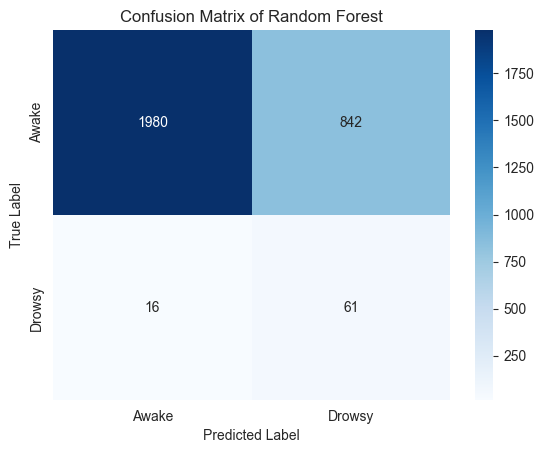

In [11]:
rf_classifier= RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search=GridSearchCV(rf_classifier, param_grid, cv=4, n_jobs=-1, verbose=2,scoring='accuracy')
grid_search.fit(X_rus, y_rus)
print("Best parameters:", grid_search.best_params_)
print("Best score: {:.2f}".format(grid_search.best_score_))
best_rf = grid_search.best_estimator_
confusion_matrix_on_test_data(best_rf, 'Random Forest', X_test, y_test)